In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [44]:
palette = sns.color_palette("Spectral", as_cmap=True)

In [32]:
cmap = 'coolwarm_r'

In [27]:
labels = pd.read_csv("labels.csv",index_col=[0]).iloc[:,0]
data = pd.read_csv("data.csv",index_col=[0])
bins = pd.read_csv("binary.csv",index_col=[0])
sims = pd.read_csv("wang_pairwise_similarities.csv",index_col=[0])

sims.index = sims.index.str.replace("DOID:","")
sims.columns = sims.columns.str.replace("DOID:","")


dsims = 1-sims

In [28]:
sims

,9351,5419,1883,9120,4606,3996,5082,437,0070004,2226,...,0060119,5041,10791,2841,2742,3721,0050742,10211,0050557,289
9351,1.000000,0.071430,0.093360,0.417263,0.047620,0.071430,0.057144,0.036757,0.041172,0.036762,...,0.057144,0.057144,0.041172,0.047529,0.071430,0.030159,0.071430,0.071430,0.041172,0.071430
5419,0.071430,1.000000,0.109892,0.109892,0.061343,0.086582,0.071430,0.047041,0.054521,0.049858,...,0.071430,0.071430,0.054521,0.059118,0.086582,0.042881,0.210270,0.086582,0.054521,0.086582
1883,0.093360,0.109892,1.000000,0.135413,0.082379,0.109892,0.093360,0.062546,0.074963,0.069899,...,0.093360,0.093360,0.074963,0.076689,0.109892,0.062330,0.109892,0.109892,0.074963,0.109892
9120,0.417263,0.109892,0.135413,1.000000,0.082379,0.109892,0.093360,0.062546,0.074963,0.069899,...,0.093360,0.093360,0.074963,0.076689,0.109892,0.062330,0.109892,0.109892,0.074963,0.109892
4606,0.047620,0.061343,0.082379,0.082379,1.000000,0.453010,0.047620,0.029820,0.238225,0.206874,...,0.549999,0.549999,0.032259,0.039738,0.061343,0.159918,0.061343,0.061343,0.032259,0.061343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3721,0.030159,0.042881,0.062330,0.062330,0.159918,0.316671,0.030159,0.016926,0.278017,0.208887,...,0.222722,0.222722,0.015887,0.025321,0.042881,1.000000,0.042881,0.042881,0.015887,0.042881
0050742,0.071430,0.210270,0.109892,0.109892,0.061343,0.086582,0.071430,0.047041,0.054521,0.049858,...,0.071430,0.071430,0.054521,0.059118,0.086582,0.042881,1.000000,0.086582,0.054521,0.086582
10211,0.071430,0.086582,0.109892,0.109892,0.061343,0.086582,0.319248,0.114243,0.054521,0.049858,...,0.071430,0.071430,0.132409,0.143573,0.210270,0.042881,0.086582,1.000000,0.132409,0.210270
0050557,0.041172,0.054521,0.074963,0.074963,0.032259,0.054521,0.099990,0.060920,0.026218,0.022082,...,0.041172,0.041172,0.063672,0.083628,0.132409,0.015887,0.054521,0.132409,1.000000,0.132409


In [29]:
# diseases = bins.sum().sort_values(ascending=False).head(50).index
# bins = bins.loc[:,diseases]
# sims = sims.loc[diseases,diseases]

In [30]:
bins.sum(axis=1).value_counts()

1    1408
2    1190
3     414
4     125
5      21
0      13
6       3
8       1
7       1
dtype: int64

# Pairwise (Dis)Similarities

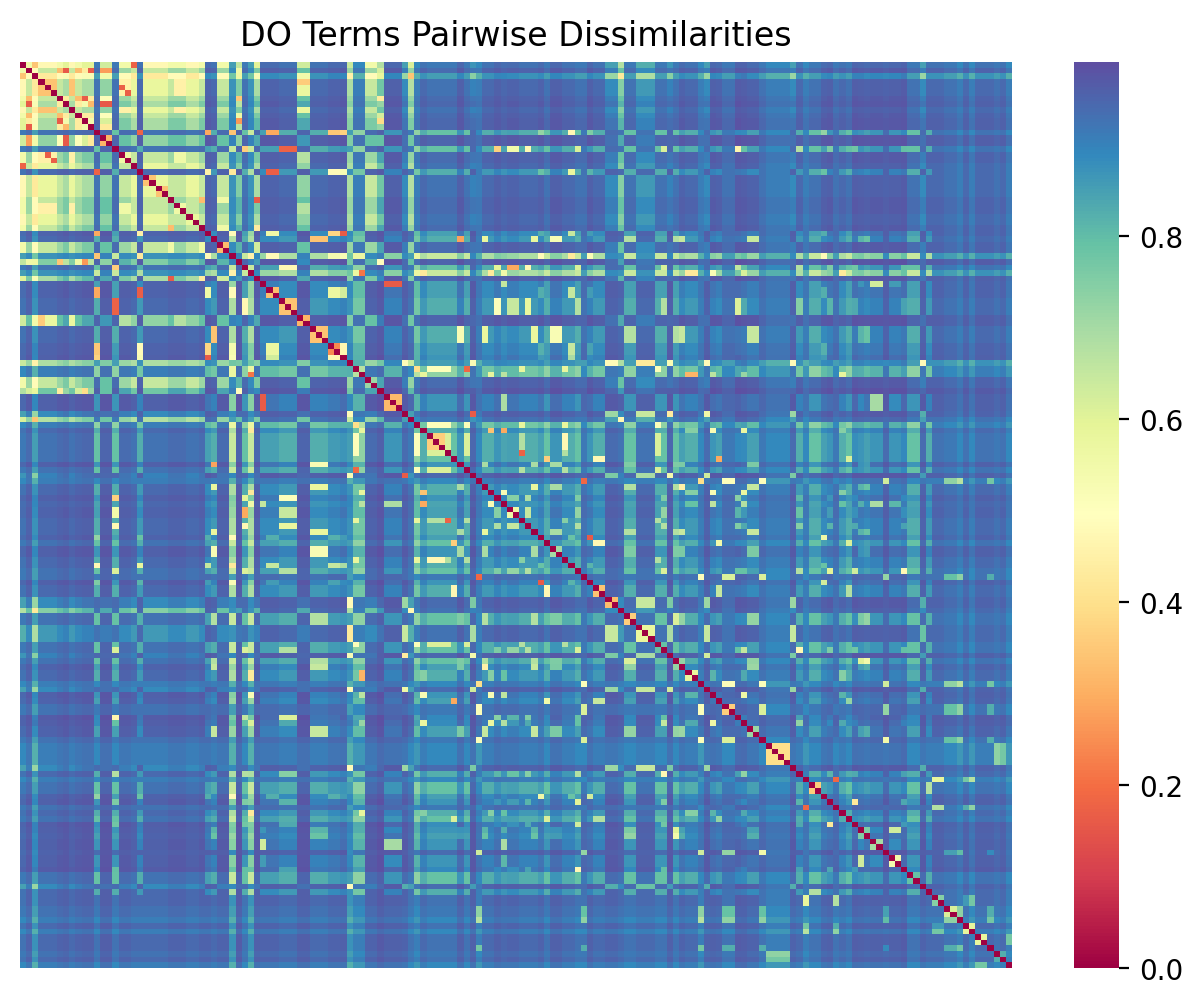

In [87]:
fig,ax = plt.subplots(figsize=(8,6),dpi=200)

sort_dsim = dsims.std().sort_values(ascending=False).index

plt.title("DO Terms Pairwise Dissimilarities")

sns.heatmap(dsims.loc[sort_dsim,sort_dsim],
            cmap = palette,
            xticklabels=False,
            yticklabels=False,
            ax = ax)

plt.savefig("DO Terms Pairwise Dissimilarities.png")

plt.show()

# Groupwise Dis/Similarities - No Semantics

In [9]:
groupwise_cosine_sim = pd.DataFrame(cosine_similarity(bins))
groupwise_cosine_dsim = 1 - groupwise_cosine_sim

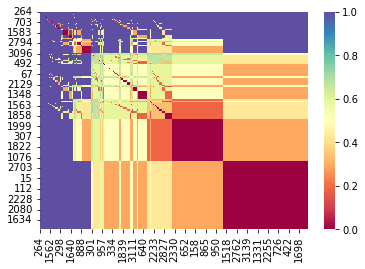

In [71]:
a = groupwise_cosine_dsim.sum().sort_values(ascending = False).index
sns.heatmap(groupwise_cosine_dsim.loc[a,a], cmap = palette)
plt.show()


# Groupwise Dis/Similarities - Semantically (Mabotuwana et al.,2013)

In [48]:
def Mabotuwana(P1,P2):
    v1 = sims.loc[P1,:]
    v2 = sims.loc[P2,:]
    num = (v1.max() * v2.max()).sum()
    den = np.power(np.power(v1.max(),2).sum(),1/2) * np.power(np.power(v2.max(),2).sum(),1/2)
    if den == 0:
        return 0 ##
    else:
        return num/den

In [49]:
bins_dict = {i:list(bins.T.loc[:,i][bins.T.loc[:,i] == 1].index) for i in bins.index}

all_combs = bins.index.map(bins_dict).value_counts().index

combs_wang_sims = pd.DataFrame({C1:{C2:Mabotuwana(all_combs[C1],all_combs[C2]) for C2 in range(len(all_combs))} for C1 in range(len(all_combs))})

combs_wang_dsims = np.round(1 - combs_wang_sims, decimals = 10)

comb_idx = pd.Series({i:str(all_combs[i]) for i in range(len(all_combs))})

for i in bins.index:

    bins.loc[i,'c_idx'] = comb_idx[comb_idx == str(bins_dict[i])].index[0]

combs_wang_sims.loc[:5,:5]

,0,1,2,3,4,5
0,1.000000,0.897491,0.897491,0.519461,0.838731,0.512081
1,0.897491,1.000000,0.889202,0.811554,0.952816,0.459180
2,0.897491,0.889202,1.000000,0.636124,0.952816,0.459180
3,0.519461,0.811554,0.636124,1.000000,0.800185,0.430202
4,0.838731,0.952816,0.952816,0.800185,1.000000,0.428662
5,0.512081,0.459180,0.459180,0.430202,0.428662,1.000000


In [50]:
groupwise_wang_sims = pd.DataFrame(data=0, index = bins.index, columns = bins.index)

for i in tqdm(groupwise_wang_sims.index):
    for j in groupwise_wang_sims.index:
        if i>j:
        
            i_c_idx = bins.loc[i,"c_idx"]
            j_c_idx = bins.loc[j,"c_idx"]
            groupwise_wang_sims.loc[i,j] = combs_wang_sims.loc[i_c_idx,j_c_idx]
            
groupwise_wang_sims += groupwise_wang_sims.T

for i in tqdm(groupwise_wang_sims.index):
    groupwise_wang_sims.loc[i,i] = 1
    
groupwise_wang_dsims = 1 - groupwise_wang_sims

100%|████████████████████████████████████| 3176/3176 [00:00<00:00, 58641.97it/s]


In [20]:
groupwise_wang_dsims.to_csv("Groupwise_Dissimilarity_All_Patients.csv")

<AxesSubplot:>

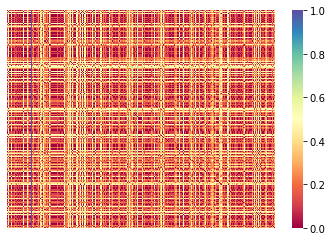

In [72]:
sort = combs_wang_dsims.sum().sort_values(ascending=False).index
sns.heatmap(groupwise_wang_dsims.loc[sort,sort],
            cmap = palette,
            xticklabels=False,
            yticklabels=False)

<AxesSubplot:>

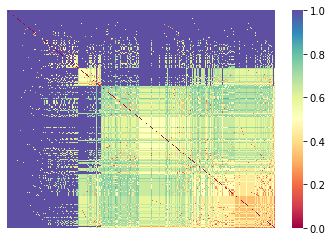

In [77]:
combs_cos_dsims = 1 - pd.DataFrame(cosine_similarity(bins.iloc[:,:-1].drop_duplicates()))
sort = combs_cos_dsims.sum().sort_values(ascending=False).index
sns.heatmap(combs_cos_dsims.loc[sort,sort], cmap = palette, xticklabels=False, yticklabels=False)

In [82]:
combs_wang_dsims

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,0.000000,0.102509,0.102509,0.480539,0.161269,0.487919,0.183518,0.499470,0.480539,0.214775,...,0.136526,0.530583,0.251333,0.231811,0.176134,0.234400,0.204433,0.201271,0.224554,0.236466
1,0.102509,0.000000,0.110798,0.188446,0.047184,0.540820,0.273854,0.379890,0.363876,0.303466,...,0.228372,0.581966,0.339850,0.190923,0.112918,0.325023,0.292495,0.296947,0.309719,0.187980
2,0.102509,0.110798,0.000000,0.363876,0.047184,0.540820,0.273854,0.471525,0.188446,0.303466,...,0.228372,0.581966,0.339850,0.263355,0.199859,0.325023,0.292495,0.296947,0.309719,0.263724
3,0.480539,0.188446,0.363876,0.000000,0.199815,0.569798,0.525000,0.285543,0.277763,0.528047,...,0.521506,0.606683,0.524313,0.315140,0.260539,0.510824,0.467220,0.495857,0.467220,0.320240
4,0.161269,0.047184,0.047184,0.199815,0.000000,0.571338,0.323671,0.401930,0.199815,0.351878,...,0.280033,0.610700,0.387106,0.234518,0.158346,0.373376,0.340872,0.347707,0.356682,0.230773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,0.234400,0.325023,0.325023,0.510824,0.373376,0.464269,0.334014,0.498865,0.510824,0.116773,...,0.362470,0.520974,0.045788,0.363816,0.340807,0.000000,0.260690,0.198066,0.270200,0.386744
461,0.204433,0.292495,0.292495,0.467220,0.340872,0.276232,0.203884,0.323003,0.467220,0.189949,...,0.326345,0.324626,0.275179,0.224243,0.177926,0.260690,-0.000000,0.235697,0.009525,0.260289
462,0.201271,0.296947,0.296947,0.495857,0.347707,0.484585,0.325632,0.517436,0.495857,0.342038,...,0.194839,0.537684,0.221660,0.365980,0.245002,0.198066,0.235697,-0.000000,0.245069,0.379553
463,0.224554,0.309719,0.309719,0.467220,0.356682,0.276232,0.217090,0.323003,0.467220,0.201769,...,0.342101,0.324626,0.284528,0.235502,0.191442,0.270200,0.009525,0.245069,-0.000000,0.272064


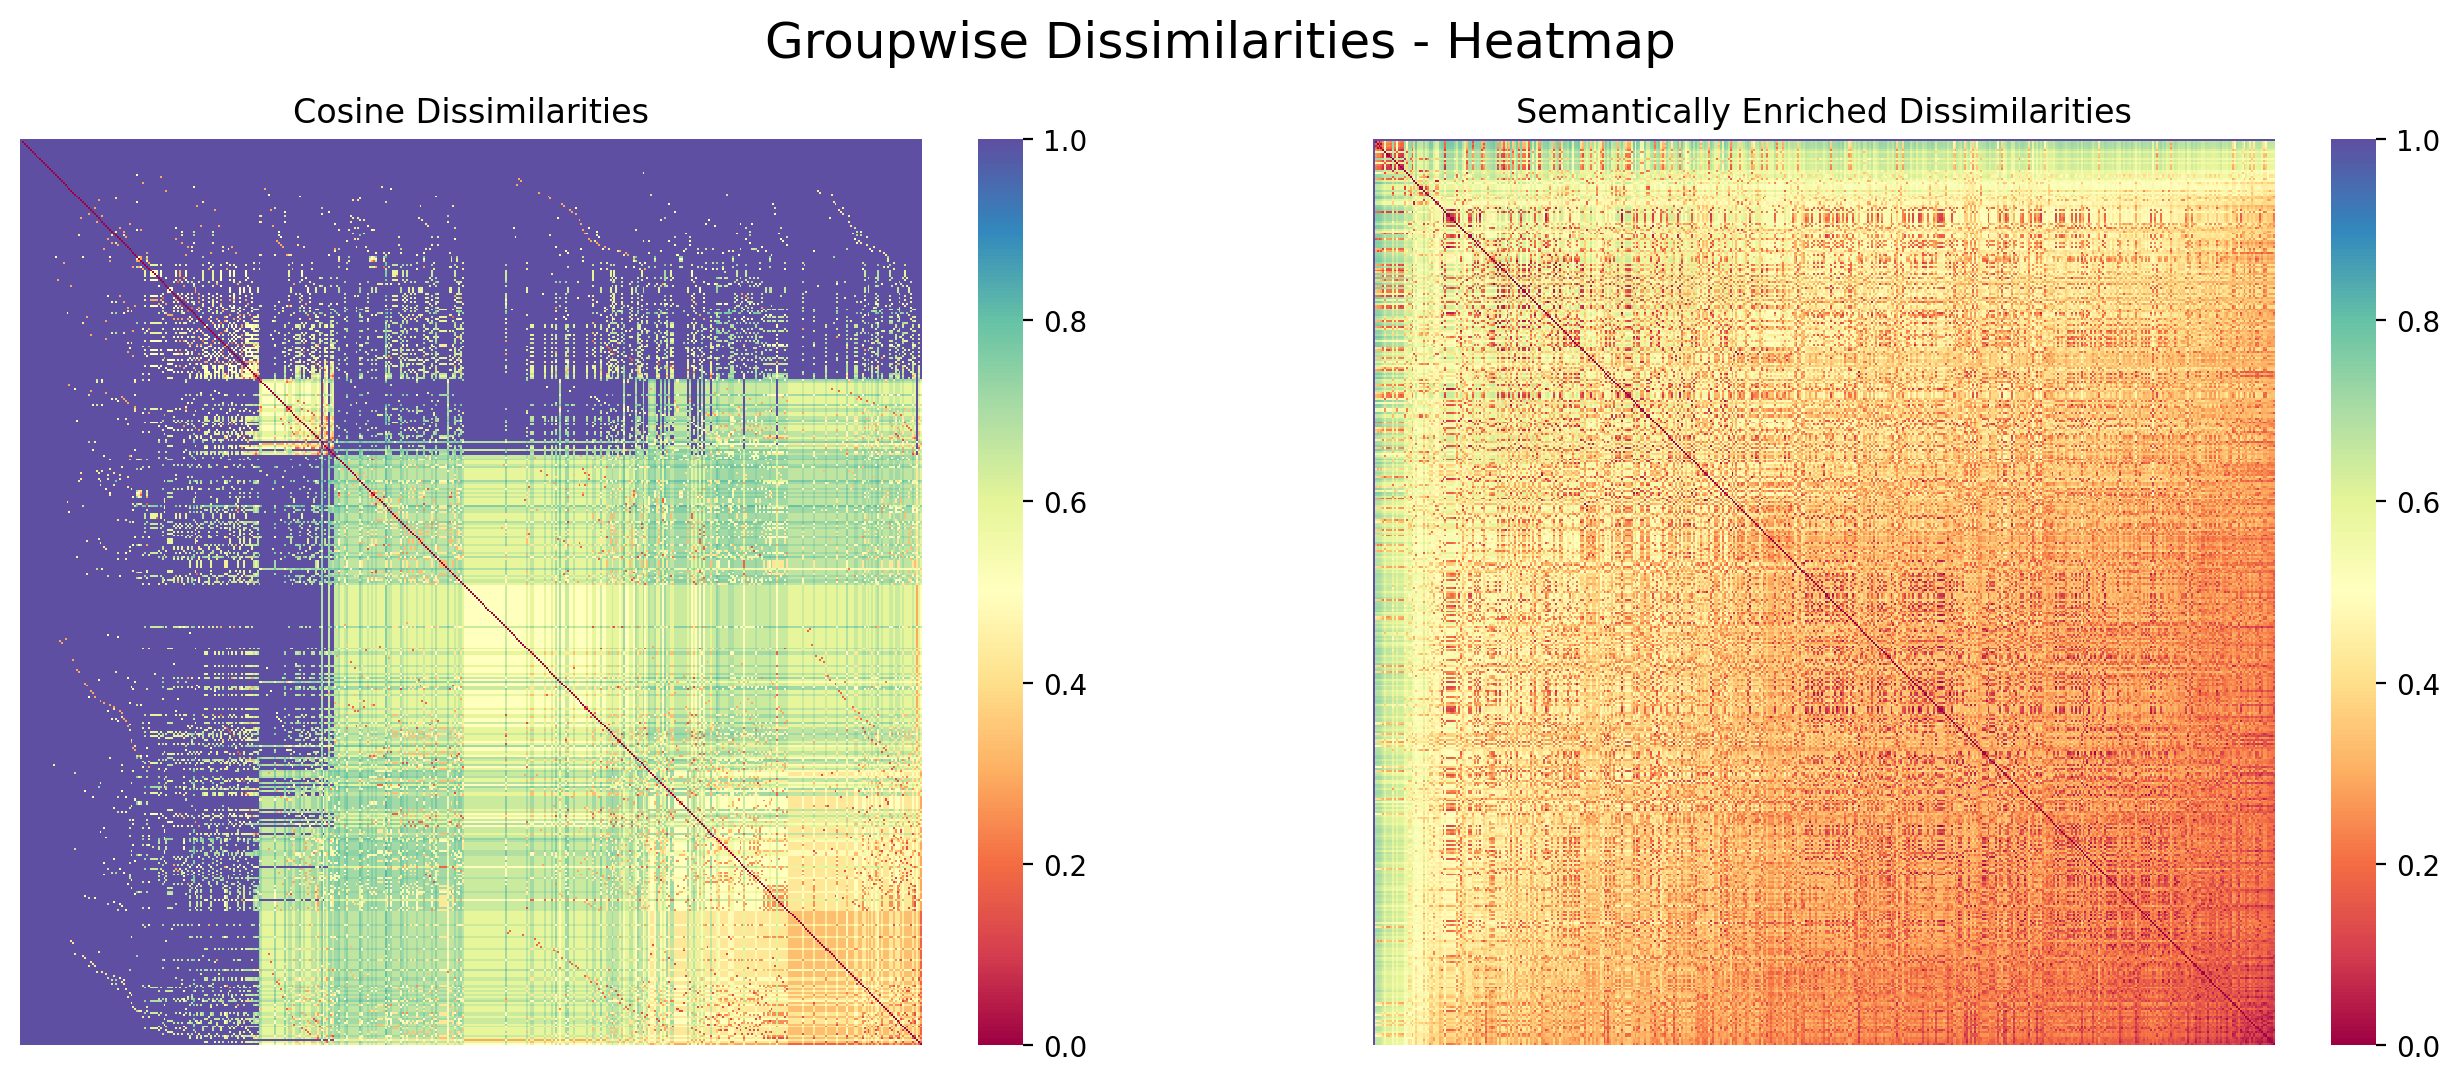

In [84]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,6),dpi=200,sharey=True)

fig.suptitle("Groupwise Dissimilarities - Heatmap", fontsize=18)

ax1.set_title("Cosine Dissimilarities")


sort = combs_cos_dsims.sum().sort_values(ascending=False).index

sns.heatmap(combs_cos_dsims.loc[sort,sort],
            cmap = palette,
            xticklabels=False,
            yticklabels=False,
            ax = ax1)

ax2.set_title("Semantically Enriched Dissimilarities")

sort = combs_wang_dsims.sum().sort_values(ascending=False).index

sns.heatmap(combs_wang_dsims.loc[sort,sort],
            cmap = palette,
            xticklabels=False,
            yticklabels=False,
            ax = ax2)

plt.savefig("Groupwise Similarities Heatmap.png")
plt.show()

<AxesSubplot:>

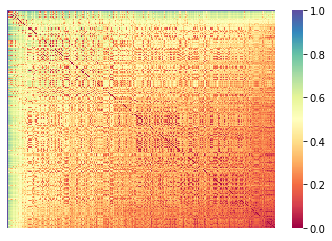

In [78]:
sort = combs_wang_dsims.sum().sort_values(ascending=False).index
sns.heatmap(combs_wang_dsims.loc[sort,sort],
            cmap = palette,
            xticklabels=False,
            yticklabels=False)

In [17]:
bins.to_csv("disease_groupwise_similarities_files/binary_with_index.csv")
combs_cos_dsims.to_csv("disease_groupwise_similarities_files/cos_dsims.csv")
combs_wang_dsims.to_csv("disease_groupwise_similarities_files/wang_dsims.csv")
comb_idx.to_csv("disease_groupwise_similarities_files/comb_idx.csv")

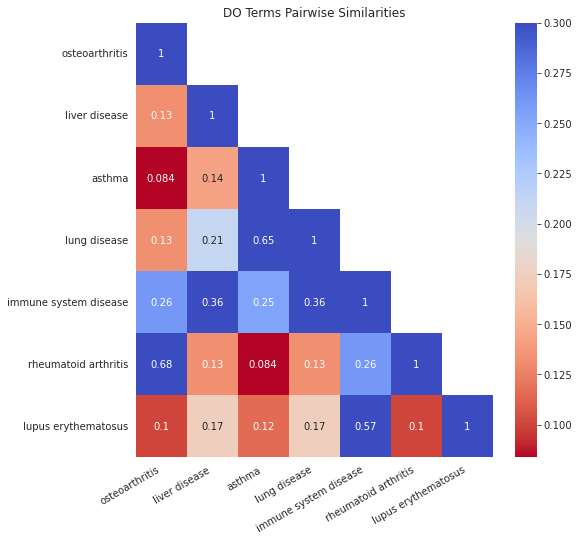

In [103]:
A = {'8398':'osteoarthritis','409':'liver disease','2841':'asthma','850':'lung disease',
      '2914':'immune system disease','7148':'rheumatoid arthritis','8857':'lupus erythematosus'}

S = sims.loc[A.keys(),A.keys()].rename(A,axis=0).rename(A,axis=1)

mask = np.zeros_like(S)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask,0.)



with sns.axes_style("white"):
    
     f, ax = plt.subplots(figsize=(8,8))
     ax = sns.heatmap(S, mask=mask, vmax=.3, square=False, annot=True, cmap=cmap)
    
plt.title("DO Terms Pairwise Similarities")
    
plt.xticks(rotation=30, ha='right')

plt.savefig("DO Terms Pairwise Similarities.svg")

plt.show()